In [221]:
%pylab inline
import pandas as pd
import numpy as np
import time
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier,\
                              GradientBoostingClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

Populating the interactive namespace from numpy and matplotlib


In [2]:
def read_csv(day_trade):
    data_up = []
    data_down = []
    path = '/home/rory/SGX-OrderBook-Tick-Data-Trading-Strategy/Train_Test_Data/ML_data_2014'
    for j,i in enumerate(day_trade):
        for k in range(0,len(i),1):
            path_up = path + '_' + str(j+1) + '_' + str(i[k]) + '_' + 'UP' + '.csv'
            path_down = path + '_' + str(j+1) + '_' + str(i[k]) + '_' + 'DOWN' + '.csv'
            data_up.append(pd.read_csv(path_up))
            data_down.append(pd.read_csv(path_down))
            #print path_down
    return data_up,data_down

In [3]:
SEED = 42
def latest_day_loop_acc(X_train,y_train,X_test,y_test,model):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = metrics.accuracy_score(y_test, preds)
    return acc

In [4]:
day_trade = [[2,3,6,7,8,10,13,14,15,16]]#,17,20,21,22,23,24,27,28,29,30],\
             #[7,10,11,12,13,17,18,19,21,24,25,26,27],\
             #[3,4,5,6,7,10,11,13,14,17,18,19,20,24,25,26,27,31]]

In [6]:
data_2014_up, data_2014_down = read_csv(day_trade)

In [322]:
models = {
    'RandomForestClassifier': RandomForestClassifier(random_state = 0),
    'ExtraTreesClassifier': ExtraTreesClassifier(random_state = 0),
    'AdaBoostClassifier': AdaBoostClassifier(base_estimator = DecisionTreeClassifier(),n_estimators = 1,random_state = 0),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state = 0),
    'SVC': SVC(probability=True,random_state = 0),
    #'LogisticRegression':LogisticRegression()
}

In [321]:
model_grid_params = {
    'RandomForestClassifier': {'max_features':[None],'n_estimators':[1],'max_depth':[10],\
                               'min_samples_split':[2],'criterion':['entropy'],\
                               'min_samples_leaf':[3]},
    'ExtraTreesClassifier': {'max_features':[None],'n_estimators':[1],'max_depth':[10],\
                             'min_samples_split':[2],'criterion':['entropy'],\
                             'min_samples_leaf':[3]},
    'AdaBoostClassifier': {"base_estimator__criterion" : ["entropy"],\
                           "base_estimator__max_depth": [None],\
                           "base_estimator__min_samples_leaf" : [3],\
                           "base_estimator__min_samples_split" : [2],\
                           "base_estimator__max_features" : [None]},
    'GradientBoostingClassifier': {'max_features':[None],'n_estimators':[1],'max_depth':[10],\
                                   'min_samples_split':[2],'min_samples_leaf':[3],\
                                   'learning_rate':[0.1],'subsample':[1.0]},
    'SVC': [{'kernel':['rbf'],'gamma':[1e-1],'C':[10]}]#,\
            #{'kernel':['linear'],'C':[1,10]}]
}

In [261]:
#params['RandomForestClassifier']

In [536]:
class Model_Selection:
    
    def __init__(self,models,model_grid_params,data_2014,latest_sec,pred_sec,day):
        
        self.models = models
        self.model_grid = model_grid_params
        self.data_2014 = data_2014
        self.latest_sec = latest_sec
        self.pred_sec = pred_sec
        self.day = day
        self.keys = models.keys()
        self.best_score = {}
        self.grid = {}
        self.predict_values = {}
        self.cv_acc = {}
        self.acc = {}
        self.fscore = {}
        self.true_values = {}
        self.predict_values_day = {}
        self.cv_acc_day = {}
        self.acc_day = {}
        self.fscore_day = {}
        self.true_values_day = {}
        self.summary_day = []
        
    def Grid_fit(self,X_train,y_train,cv = 5,scoring = 'accuracy'):
        
        for key in self.keys:
            print "Running GridSearchCV for %s." %(key)
            model = self.models[key]
            model_grid = self.model_grid[key]
            Grid = GridSearchCV(model, model_grid, cv = cv, scoring = scoring)
            Grid.fit(X_train,y_train) 
            self.grid[key] = Grid
            print Grid.best_params_
            print 'CV Best Score = %s'%(Grid.best_score_)
            self.cv_acc[key].append(Grid.best_score_)  
    
    def model_fit(self,X_test,y_test):
        
        for key in self.keys:
            print "Running training & testing for %s." %(key)
            model = self.models[key]
            model.set_params(**self.grid[key].best_params_)
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)
            print 'Prediction latest 15 second = %s'%(predictions)
            self.predict_values[key].append(predictions.tolist())
            self.true_values[key].append(y_test.tolist())
            acc = metrics.accuracy_score(y_test,predictions)
            f_score = metrics.f1_score(y_test,predictions)
            print 'Accuracy = %s'%(acc)
            self.acc[key].append(acc)
            self.fscore[key].append(f_score)
            
            if key == 'SVC':
                if self.grid[key].best_params_.values()[0] == 'linear':
                    feature_imp = dict(zip([i for i in range(0,64,1)],model.coef_[0]))
                    Top_five = sorted(feature_imp.items(),key = lambda x : x[1] , reverse=True)[0:5]
                    #print 'Kernel is linear and top five importance features = %s'%(Top_five)
                else:
                    #print 'Kernel is rbf'
                    pass
            else: 
                feature_imp = dict(zip([i for i in range(0,64,1)],model.feature_importances_))
                Top_five = sorted(feature_imp.items(),key = lambda x : x[1] , reverse=True)[0:5]
                #print 'Top five importance features = %s'%(Top_five)
                pass

    def pipline(self):
        
        for day in range(0,self.day,1):
            self.set_list() # store values
            print 'Day = %s'%(day+1)
            for i in range(0,100,self.pred_sec):#9000 - self.latest_sec - self.pred_sec, self.pred_sec):
                
                print '----------------------------Rolling Window Time = %s----------------------------'%(i/pred_sec)
                # Train data
                data_train = self.data_2014[day][i:i+self.latest_sec]
                X_train = data_train.drop(["0"],axis=1)
                y_train = data_train['0']

                # Test data
                data_test = self.data_2014[day][i + self.latest_sec:i + self.latest_sec + self.pred_sec]
                X_test = data_test.drop(["0"],axis=1)
                y_test = data_test['0']
                
                start = time.time()
                self.Grid_fit(X_train, y_train, cv = 5, scoring = 'accuracy')
                self.model_fit(X_test,y_test)
                end = time.time()
                print 'Total Time = %s'%(end - start)
                
            for key in self.keys:
                self.cv_acc_day[key].append(self.cv_acc[key])
                self.acc_day[key].append(self.acc[key])
                self.fscore_day[key].append(self.fscore[key])
                self.true_values_day[key].append(self.true_values[key])
            
            self.summary_day.append(self.score_summary(sort_by = 'Accuracy_mean'))
    
    def set_list(self):
        
        for key in self.keys:
            self.predict_values[key] = []
            self.cv_acc[key] = []
            self.acc[key] = []
            self.fscore[key] = []
            self.true_values[key] = []
            self.predict_values_day[key] = []
            self.cv_acc_day[key] = []
            self.acc_day[key] = []
            self.fscore_day[key] = []
            self.true_values_day[key] = []
            
    def score_summary(self,sort_by):
        
        summary = pd.concat([pd.DataFrame(self.acc.keys()),pd.DataFrame(map(lambda x: mean(self.acc[x]), self.acc)),\
                             pd.DataFrame(map(lambda x: std(self.acc[x]), self.acc)),\
                             pd.DataFrame(map(lambda x: max(self.acc[x]), self.acc)),\
                             pd.DataFrame(map(lambda x: min(self.acc[x]), self.acc)),\
                             pd.DataFrame(map(lambda x: mean(self.fscore[x]), self.fscore))],axis=1)
        summary.columns = ['Estimator','Accuracy_mean','Accuracy_std','Accuracy_max','Accuracy_min','F_score']
        summary.index.rename('Ranking', inplace=True)
        return summary.sort_values(by = [sort_by], ascending=False)
          
    def print_(self):
        print self.predict_values
        
        
        

In [534]:
latest_sec = 60 * 30
pred_sec = 10
day = 2
data_2014 = data_2014_up
pip = Model_Selection(models,model_grid_params,data_2014,latest_sec,pred_sec,day)

In [535]:
pip.pipline()

Day = 1
----------------------------Rolling Window Time = 0----------------------------
Running GridSearchCV for SVC.
{'kernel': 'rbf', 'C': 10, 'gamma': 0.1}
CV Best Score = 0.815
Running GridSearchCV for AdaBoostClassifier.
{'base_estimator__min_samples_split': 2, 'base_estimator__criterion': 'entropy', 'base_estimator__max_depth': None, 'base_estimator__min_samples_leaf': 3, 'base_estimator__max_features': None}
CV Best Score = 0.712777777778
Running GridSearchCV for GradientBoostingClassifier.
{'subsample': 1.0, 'learning_rate': 0.1, 'min_samples_leaf': 3, 'n_estimators': 1, 'min_samples_split': 2, 'max_features': None, 'max_depth': 10}
CV Best Score = 0.702777777778
Running GridSearchCV for ExtraTreesClassifier.
{'min_samples_leaf': 3, 'n_estimators': 1, 'min_samples_split': 2, 'criterion': 'entropy', 'max_features': None, 'max_depth': 10}
CV Best Score = 0.720555555556
Running GridSearchCV for RandomForestClassifier.
{'min_samples_leaf': 3, 'n_estimators': 1, 'min_samples_split':

AttributeError: 'dict' object has no attribute 'append'

In [520]:
pip.summary_day[0]

,Estimator,Accuracy_mean,Accuracy_std,Accuracy_max,Accuracy_min,F_score
Ranking,,,,,,
2,SVC,1.00,0.000000,1.0,1.0,1.000000
3,GradientBoostingClassifier,1.00,0.000000,1.0,1.0,1.000000
4,RandomForestClassifier,0.94,0.180000,1.0,0.4,0.957143
0,ExtraTreesClassifier,0.92,0.183303,1.0,0.4,0.946032
1,AdaBoostClassifier,0.91,0.181384,1.0,0.4,0.940769


In [537]:
for i in range(0,5,1):
    plot(np.array(pip.cv_acc_day[0])[i])

KeyError: 0

In [544]:
pip.cv_acc_day

{'AdaBoostClassifier': [[0.71277777777777773,
   0.72944444444444445,
   0.71888888888888891,
   0.68666666666666665,
   0.72444444444444445,
   0.66000000000000003,
   0.7072222222222222,
   0.78000000000000003,
   0.72388888888888892,
   0.7794444444444445]],
 'ExtraTreesClassifier': [[0.7205555555555555,
   0.79777777777777781,
   0.79777777777777781,
   0.7927777777777778,
   0.79333333333333333,
   0.71111111111111114,
   0.77555555555555555,
   0.6544444444444445,
   0.71722222222222221,
   0.72999999999999998]],
 'GradientBoostingClassifier': [[0.70277777777777761,
   0.7038888888888889,
   0.7038888888888889,
   0.7038888888888889,
   0.70777777777777773,
   0.71333333333333337,
   0.71888888888888891,
   0.72444444444444445,
   0.72833333333333339,
   0.72833333333333339]],
 'RandomForestClassifier': [[0.71777777777777774,
   0.73611111111111116,
   0.7005555555555556,
   0.73333333333333328,
   0.66166666666666663,
   0.67944444444444441,
   0.755,
   0.68555555555555558,
   

In [556]:
for key in pip.keys:
    print key
    print np.array(pip.cv_acc_day[key])[0][0]

SVC
0.815
AdaBoostClassifier
0.712777777778
GradientBoostingClassifier
0.702777777778
ExtraTreesClassifier
0.720555555556
RandomForestClassifier
0.717777777778


In [564]:
#np.array(pip.cv_acc_day.values())

In [291]:
#np.array(pip.CV_acc.values())#,pip.acc,pip.predict_values,pip.true_values

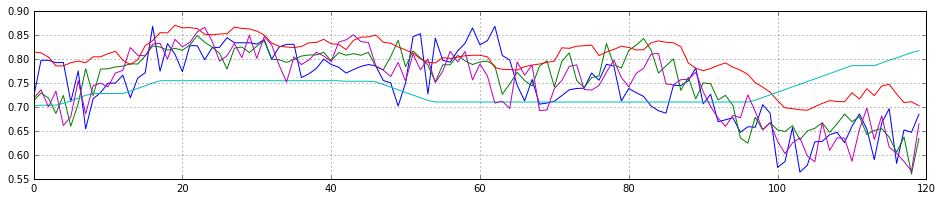

In [326]:
plt.figure(figsize = (16,3))
plt.grid()
for i in range(0,5,1):
    plot(np.array(pip.CV_acc.values())[i])

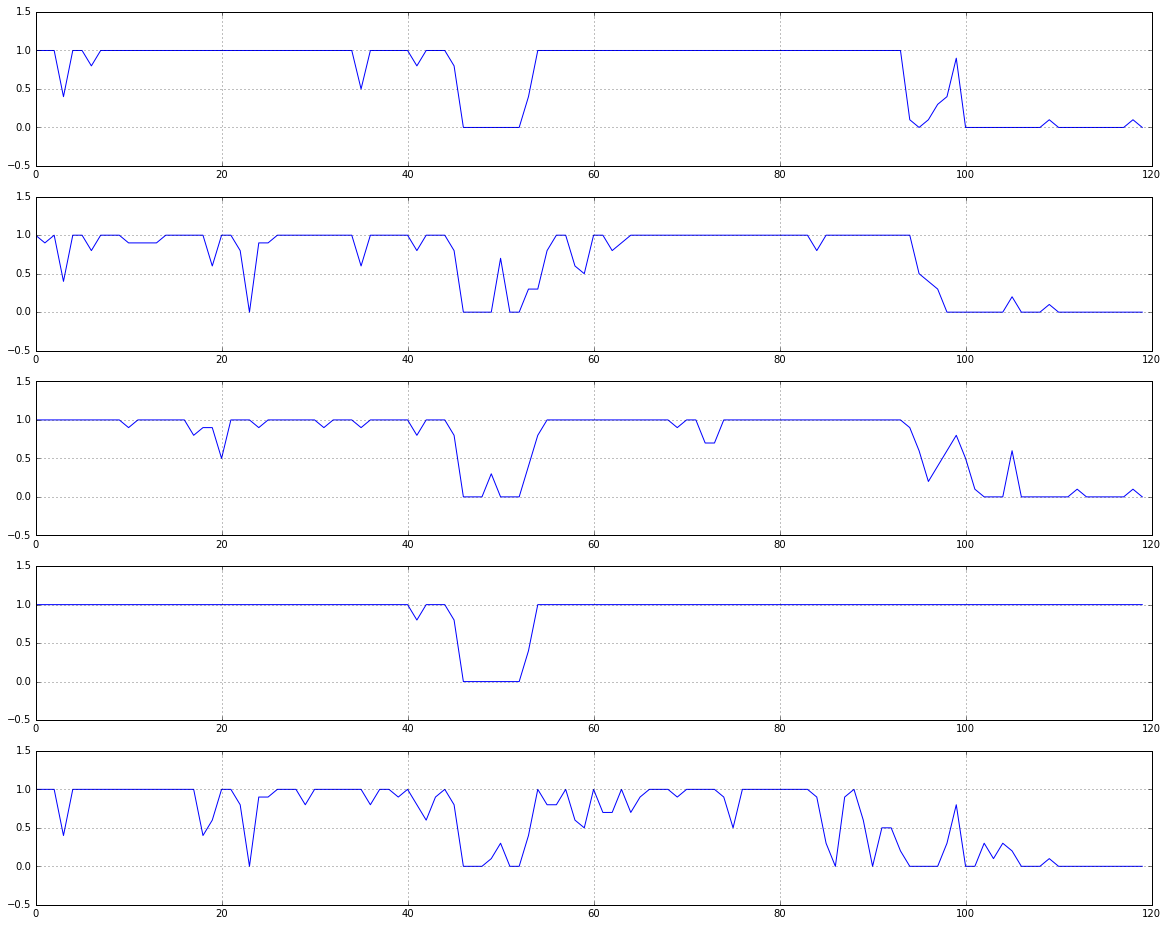

In [327]:
plt.figure(figsize = (20,16))
for i in range(0,5,1):
    k = 510
    plt.subplot(k+i+1)
    plot(np.array(pip.acc.values()[i]))
    plt.ylim(-0.5,1.5)
    plt.grid()